In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score, train_test_split, RepeatedStratifiedKFold, cross_validate, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report, accuracy_score, f1_score


## Data Preprocess

In [2]:
# data preprocess 
df = pd.read_csv('heart.csv')
df.head()

X = df.drop(columns='HeartDisease')
y = df['HeartDisease']

categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

preprocessor = ColumnTransformer([
    ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
    ('scaler', StandardScaler(), numerical_cols)
])

In [3]:
# train/ test/ validation set split
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=100
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, stratify=y_train_val, random_state=100
)

## Use GridSearchCV find the best solver (tuning hyper parameter $c$)
After tuning logistic regression with different solvers and C values, the best setup was **liblinear with C = 1**. It gave the highest cross-validated F1-score of 0.8788. In this task, misclassifying positive cases (patients with the disease) carries a higher cost. Therefore, F1-score would be a more appropriate metric for evaluation. 

Best solver and C: {'logreg__C': 1, 'logreg__solver': 'liblinear'}
Best cross-validated F1-score: 0.8788
Final classification report on test set:
              precision    recall  f1-score   support

           0       0.79      0.83      0.81        82
           1       0.86      0.82      0.84       102

    accuracy                           0.83       184
   macro avg       0.82      0.83      0.82       184
weighted avg       0.83      0.83      0.83       184

Mean F1-score across folds:
param_logreg__solver   lbfgs  liblinear  newton-cg     sag    saga
param_logreg__C                                                   
0.1                   0.8786     0.8787     0.8786  0.8786  0.8786
0.5                   0.8786     0.8786     0.8786  0.8786  0.8786
1                     0.8782     0.8788     0.8782  0.8782  0.8782
2                     0.8783     0.8788     0.8783  0.8783  0.8783


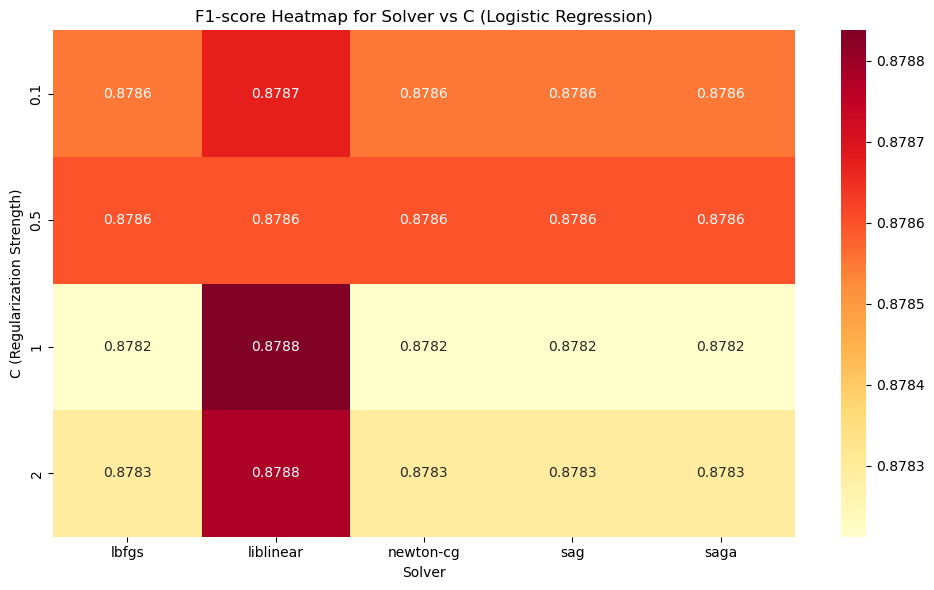

In [4]:
# Use c to find the best solver
param_grid = {
    'logreg__solver': ['liblinear', 'lbfgs', 'sag', 'saga', 'newton-cg'],
    'logreg__C': [0.1, 0.5, 1, 2]

}

model = Pipeline([
    ('preprocess', preprocessor),
    ('logreg', LogisticRegression(max_iter=1000))
])

grid = GridSearchCV(
    model,
    param_grid,
    scoring='f1',
    cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=100),
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("Best solver and C:", grid.best_params_)
print("Best cross-validated F1-score:", round(grid.best_score_, 4))


y_pred = grid.best_estimator_.predict(X_test)
print("Final classification report on test set:")
print(classification_report(y_test, y_pred))

# Pivot table
results = pd.DataFrame(grid.cv_results_)
pivot = results.pivot(index='param_logreg__C', columns='param_logreg__solver', values='mean_test_score')
pivot_sorted = pivot.sort_index().reindex(sorted(pivot.columns), axis=1)
print("Mean F1-score across folds:")
print(pivot.round(4))

# Heatmap for better visualization
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_sorted, annot=True, fmt=".4f", cmap="YlOrRd")
plt.title("F1-score Heatmap for Solver vs C (Logistic Regression)")
plt.xlabel("Solver")
plt.ylabel("C (Regularization Strength)")
plt.tight_layout()
plt.show()

## Compare approaches to improve logistic regression
Though our baseline logistic regression model already performed well, we explored a few ways to improve it — including adjusting class weights, using a different scaling method (RobustScaler), and applying feature selection with SelectKBest.  

Among all the approaches, using SelectKBest for feature selection gave us the best results, achieving the highest F1-score of **0.8792** and matching the highest validation accuracy at **86.35%**. So for our final logistic regression model, we’ll go with the **SelectKBest** version.

In [5]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
scoring = {'accuracy': 'accuracy', 'f1': 'f1'}

def evaluate_model(name, pipeline):
    scores = cross_validate(pipeline, X, y, scoring=scoring, cv=cv)
    print(f"{name:<20} → Accuracy: {scores['test_accuracy'].mean():.4f} | F1-score: {scores['test_f1'].mean():.4f}")
    return {
        'model': name,
        'accuracy': scores['test_accuracy'].mean(),
        'f1': scores['test_f1'].mean()
    }

results = []

# Method 1: Baseline Logistic Regression with StandardScaler
pipe1 = Pipeline([
    ('preprocess', ColumnTransformer([
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])),
    ('logreg', LogisticRegression(solver='liblinear'))
])
results.append(evaluate_model("Baseline", pipe1))

# Method 2: Logistic Regression with class_weight='balanced'
pipe2 = Pipeline([
    ('preprocess', ColumnTransformer([
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])),
    ('logreg', LogisticRegression(solver='liblinear', class_weight='balanced'))
])
results.append(evaluate_model("Class Weight Balanced", pipe2))

# Method 3: Logistic Regression with RobustScaler
pipe3 = Pipeline([
    ('preprocess', ColumnTransformer([
        ('num', RobustScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])),
    ('logreg', LogisticRegression(solver='liblinear'))
])
results.append(evaluate_model("Robust Scaler", pipe3))

# Method 4: Logistic Regression with SelectKBest (numerical only)
pipe4 = Pipeline([
    ('preprocess', ColumnTransformer([
        ('num', Pipeline([
            ('scaler', StandardScaler()),
            ('select', SelectKBest(score_func=f_classif, k=5))
        ]), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])),
    ('logreg', LogisticRegression(solver='liblinear'))
])
results.append(evaluate_model("SelectKBest Features", pipe4))

# Compare all methods
results_df = pd.DataFrame(results).sort_values(by='f1', ascending=False)
print("\nComparison Results (sorted by F1-score):")
print(results_df)

Baseline             → Accuracy: 0.8631 | F1-score: 0.8786
Class Weight Balanced → Accuracy: 0.8599 | F1-score: 0.8738
Robust Scaler        → Accuracy: 0.8635 | F1-score: 0.8789
SelectKBest Features → Accuracy: 0.8635 | F1-score: 0.8792

Comparison Results (sorted by F1-score):
                   model  accuracy        f1
3   SelectKBest Features  0.863479  0.879166
2          Robust Scaler  0.863479  0.878943
0               Baseline  0.863119  0.878566
1  Class Weight Balanced  0.859852  0.873759


## Final Modeling

In [6]:
# possible k candidates for SlectKBest approach
num_features = len(numerical_cols)

if num_features <= 7:
    k_values = list(range(1, num_features + 1))
else:
    k_values = list(range(3, min(num_features, 15) + 1, 2))

print("Candidate k values for feature selection:", k_values)

Candidate k values for feature selection: [1, 2, 3, 4, 5, 6]


In [23]:
# find best k value 
best_k = None
best_f1 = 0

for k in k_values:
    pipe = Pipeline([
        ('preprocess', ColumnTransformer([
            ('num', Pipeline([
                ('scaler', StandardScaler()),
                ('select', SelectKBest(score_func=f_classif, k=k))
            ]), numerical_cols),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
        ])),
        ('logreg', LogisticRegression(solver='liblinear', C=1, max_iter=1000))
    ])

    f1 = cross_val_score(pipe, X, y, scoring='f1', cv=5).mean()
    print(f"k = {k}: F1-score = {f1:.4f}")

    if f1 > best_f1:
        best_f1 = f1
        best_k = k

print(f"Best k = {best_k} with F1-score = {best_f1:.4f}")

k = 1: F1-score = 0.8491
k = 2: F1-score = 0.8506
k = 3: F1-score = 0.8420
k = 4: F1-score = 0.8454
k = 5: F1-score = 0.8438
k = 6: F1-score = 0.8444
Best k = 2 with F1-score = 0.8506


In [22]:
# Final preprocessing using best k = 2
final_preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('scaler', StandardScaler()),
        ('select', SelectKBest(score_func=f_classif, k=2)) 
    ]), numerical_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

# Final logistic regression model with best solver and C
final_model = Pipeline([
    ('preprocess', final_preprocessor),
    ('logreg', LogisticRegression(solver='liblinear', C=1, max_iter=1000))
])

# Fit model
final_model.fit(X_train, y_train)

# Evaluate on validation set
val_acc = final_model.score(X_val, y_val)
print(f"Validation Accuracy: {val_acc:.4f}")

# Evaluate on test set
y_pred = final_model.predict(X_test)
print("Final classification report on test set:")
print(classification_report(y_test, y_pred))


Validation Accuracy: 0.8261
Final classification report on test set:
              precision    recall  f1-score   support

           0       0.81      0.85      0.83        82
           1       0.88      0.84      0.86       102

    accuracy                           0.85       184
   macro avg       0.85      0.85      0.85       184
weighted avg       0.85      0.85      0.85       184



The Logistic Regression model achieved 85% accuracy on the test set, with precision of 0.83 and recall of 0.85 for the non-disease group, and precision of 0.88 and recall of 0.84 for the disease group. These scores suggest that the model performs reasonably well in separating the two classes based on the available features.

However, Logistic Regression assumes a linear relationship between the input features and the log-odds of the outcome. This assumption can limit its flexibility when the true decision boundary is non-linear or complex. In datasets like this, where interactions between features or nonlinear patterns may exist, such limitations can result in suboptimal classification performance compared to more flexible models.